# Hyporheyc exchange calculations

- Read results from the turbulent-pressure and time-averaged subsurface models
- Plot results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from natsort import natsorted

from scipy.stats import linregress
import os
from natsort import natsorted
import pyvista as pv

from he_utilities import *
set_matplotlib_customization(plt)

from myusefultools.parser import integrateDataOverTime

Read the `suspendedClay` and `phi` fields from the OpenFOAM results. 

In [2]:
fields = ["suspendedClay", "phi"]
time_averaged = retrieveVariables("./subsurface_results_folder/refactored_dp9.RANS", fields)
les_turbulent  = retrieveVariables("./subsurface_results_folder/refactored_dp9A.LES", fields)

Each dataframe row corresponds to a time value and each column represents the extracted fields. Note that each element of the dataframe is a vector, with size the number of elements in the sediment interface.

In [3]:
time_averaged

,Time (s),suspendedClay,phi
0,3600.0,"[0.320383, 0.320383, 0.320383, 0.320383, 0.320...","[-9.68572e-09, -9.40258e-09, -9.89524e-09, -9...."
1,7200.0,"[0.290383, 0.290383, 0.290383, 0.290383, 0.290...","[-9.61378e-09, -9.34831e-09, -9.82572e-09, -9...."
2,10800.0,"[0.270256, 0.270256, 0.270256, 0.270256, 0.270...","[-9.54865e-09, -9.29883e-09, -9.76265e-09, -9...."
3,14400.0,"[0.250256, 0.250256, 0.250256, 0.250256, 0.250...","[-9.48887e-09, -9.25314e-09, -9.70467e-09, -9...."
4,18000.0,"[0.235192, 0.235192, 0.235192, 0.235192, 0.235...","[-9.43376e-09, -9.21073e-09, -9.65109e-09, -9...."
...,...,...,...
307,1108800.0,"[0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.1...","[-3.99028e-09, -4.04514e-09, -4.01225e-09, -3...."
308,1112400.0,"[0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.1...","[-3.98258e-09, -4.03718e-09, -4.00423e-09, -3...."
309,1116000.0,"[0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.1...","[-3.97491e-09, -4.02924e-09, -3.99623e-09, -3...."
310,1119600.0,"[0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.1...","[-3.96725e-09, -4.02131e-09, -3.98826e-09, -3...."


In [4]:
les_turbulent

,Time (s),suspendedClay,phi
0,3.600009e+03,"[0.320383, 0.320383, 0.320383, 0.320383, 0.320...","[-5.03488e-09, -5.79159e-09, -7.20007e-09, -9...."
1,7.200018e+03,"[0.224084, 0.290383, 0.290383, 0.290383, 0.290...","[4.20723e-11, -3.3094e-09, -6.89708e-09, -1.15..."
2,1.079998e+04,"[0.270256, 0.270256, 0.270256, 0.270256, 0.204...","[-8.37559e-09, -3.81102e-09, -3.62382e-09, -6...."
3,1.439999e+04,"[0.250256, 0.250256, 0.250256, 0.250256, 0.250...","[-1.26629e-08, -1.08354e-08, -7.82062e-09, -5...."
4,1.800000e+04,"[0.178556, 0.235192, 0.235192, 0.235192, 0.235...","[1.2138e-09, -4.16204e-11, -1.14976e-09, -1.54..."
...,...,...,...
307,1.108800e+06,"[0.12, 0.12, 0.12, 0.12, 0.104199, 0.10367, 0....","[-3.16657e-09, -2.8401e-09, -2.3362e-09, -5.10..."
308,1.112400e+06,"[0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.1...","[-8.76624e-09, -1.14841e-08, -1.31033e-08, -1...."
309,1.116000e+06,"[0.102311, 0.102897, 0.103009, 0.12, 0.12, 0.1...","[2.15625e-09, 1.50775e-09, 6.18581e-10, -5.646..."
310,1.119600e+06,"[0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.1...","[-2.77183e-09, -2.83551e-09, -2.91205e-09, -2...."


### Calculate Elliot-Brooks model for reference

In [5]:
## Elliot-Brooks phi
hydCond = 1.3E-3
head_m  = 2.39E-4
bed_wavelenght = 0.15
depth_bed = 0.20
channel_width = 0.29
porosity = 0.33
Axy = bed_wavelenght*channel_width

qBar = (2*hydCond * head_m / bed_wavelenght) * np.tanh(2*np.pi*depth_bed/bed_wavelenght)
print(f"qBar = {qBar:.2E} m/s")

qBar *= Axy
print(f"qBar = {qBar:.2E} m3/s")

qBar = 4.14E-06 m/s
qBar = 1.80E-07 m3/s


Extract fluxes into the bed (negative `phi`) and integrate over the bedform length

In [6]:
for df in [time_averaged, les_turbulent]:

    df['Time (d)'] = df['Time (s)']/86400
    df['sumPhiIn (m3/s)']  = [ np.sum(np.minimum(p,0)) for p in df['phi'] ]
    df['sumPhiOut (m3/s)'] = [ np.sum(np.maximum(p,0)) for p in df['phi'] ]
    df['sumPhiNet (m3/s)'] = [ np.sum(p) for p in df['phi'] ]
    
    for field in fields: 
        df[f'massIn {field} (kg/s/m2)']  = [ np.sum(np.multiply(np.minimum(p,0),c))/Axy for p,c in zip(df['phi'],df[field]) ]
        df[f'massOut {field} (kg/s/m2)'] = [ np.sum(np.multiply(np.maximum(p,0),c))/Axy for p,c in zip(df['phi'],df[field]) ]
        df[f'massNet {field} (kg/s/m2)'] = [ np.sum(np.multiply(p,c))/Axy for p,c in zip(df['phi'],df[field]) ]

Plot evolution over time

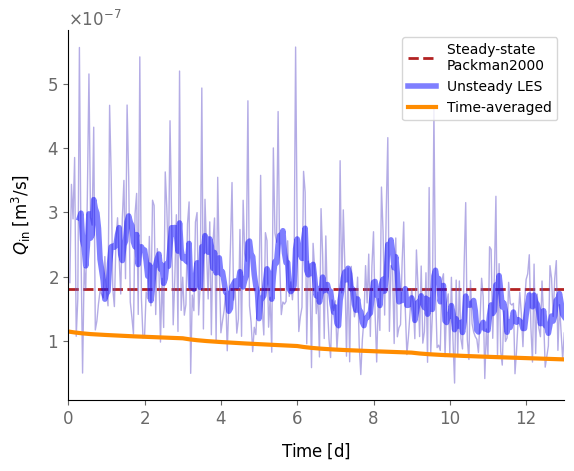

In [7]:
fig,ax = plt.subplots()
ax.axhline(y=qBar,label='Steady-state \nPackman2000',
           c='firebrick',lw=2, ls="dashed")
ax.plot(les_turbulent['Time (d)'],-les_turbulent['sumPhiIn (m3/s)'],
        c='slateblue',alpha=0.5,lw=1)
ax.plot(les_turbulent['Time (d)'],-les_turbulent['sumPhiIn (m3/s)'].rolling(7).mean(),label='Unsteady LES',
        c='blue',alpha=0.5,lw=4)
ax.plot(time_averaged['Time (d)'],-time_averaged['sumPhiIn (m3/s)'],label='Time-averaged',
        c='darkorange',lw=3)

ax.set(ylabel=r"$Q_\mathsf{in} \; \mathsf{[m^3/s]}$",
       xlabel=r"$\mathsf{Time \; [d]}$",
       xlim=(0,13))

ax.ticklabel_format(axis='y', useMathText=True)

ax.legend()
plt.show()

### Filtered clay

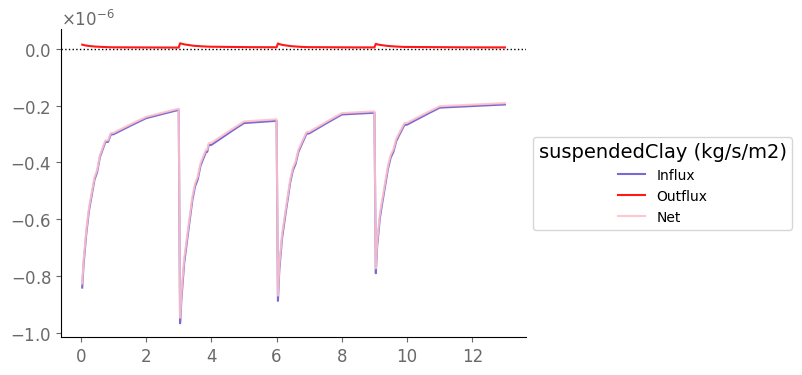

In [8]:
df,field = time_averaged, "suspendedClay"

fig,ax = plt.subplots(sharex=True,figsize=[6,4])
ax.plot(df['Time (d)'],df[f'massIn {field} (kg/s/m2)'],label='Influx',
        c='slateblue',alpha=0.9,lw=1.5)
ax.plot(df['Time (d)'],df[f'massOut {field} (kg/s/m2)'],label='Outflux',
        c='red',alpha=0.9,lw=1.5)
ax.plot(df['Time (d)'],df[f'massNet {field} (kg/s/m2)'],label='Net',
        c='pink',alpha=0.9,lw=1.5)
ax.axhline(y=0,ls=':',lw=1,c='k')

ax.ticklabel_format(axis='y', useMathText=True)
ax.legend(loc='center left',bbox_to_anchor=(1.0,0.5),title=field+" (kg/s/m2)")
plt.show()

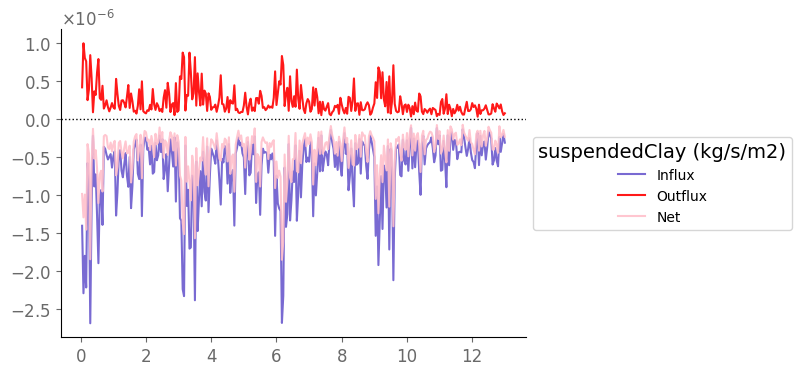

In [9]:
df,field = les_turbulent, "suspendedClay"

fig,ax = plt.subplots(sharex=True,figsize=[6,4])
ax.plot(df['Time (d)'],df[f'massIn {field} (kg/s/m2)'],label='Influx',
        c='slateblue',alpha=0.9,lw=1.5)
ax.plot(df['Time (d)'],df[f'massOut {field} (kg/s/m2)'],label='Outflux',
        c='red',alpha=0.9,lw=1.5)
ax.plot(df['Time (d)'],df[f'massNet {field} (kg/s/m2)'],label='Net',
        c='pink',alpha=0.9,lw=1.5)
ax.axhline(y=0,ls=':',lw=1,c='k')

ax.ticklabel_format(axis='y', useMathText=True)
ax.legend(loc='center left',bbox_to_anchor=(1.0,0.5),title=field+" (kg/s/m2)")
plt.show()

## Integrate deposited clay over the domain

In [10]:
path = "./subsurface_results_folder/refactored_dp9.RANS"
RASv = integrateDataOverTime(path)
RASv.drop(columns=["U","hPrime2Mean","Volume","cellID"],inplace=True)

path = "./subsurface_results_folder/refactored_dp9A.LES"
LESv = integrateDataOverTime(path)
LESv.drop(columns=["U","hPrime2Mean","Volume","cellID"],inplace=True)

LESv['Time (d)'] = LESv['Time (s)']/86400
RASv['Time (d)'] = RASv['Time (s)']/86400


#### Plot the total clay accumulation over time 

- Add a linear regression to the data to quantify the rate of deposition. This is not straightforward because the clay concentration was not constant, but followed the injections described in Fox et al. 2018.

In [11]:
RASReg = linregress(RASv['Time (d)'],RASv['depositedClay']/Axy)
LESReg = linregress(LESv['Time (d)'],LESv['depositedClay']/Axy)

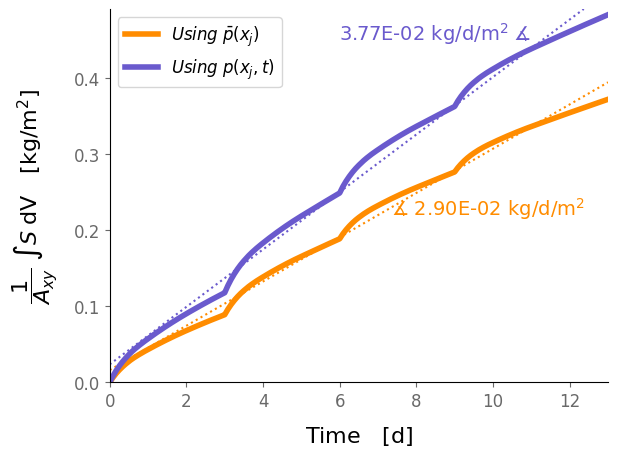

In [12]:
fig,ax = plt.subplots(tight_layout=True)
ax.plot(RASv['Time (d)'],RASv['depositedClay']/Axy,
        lw=4,label=r'${Using \; \bar{p}(x_j)}$',c='darkorange')
ax.axline((0,RASReg.intercept),slope=RASReg.slope,c='darkorange',ls='dotted')

ax.plot(LESv['Time (d)'],LESv['depositedClay']/Axy,
        lw=4,label=r'${Using \; p(x_j,t)}$',c='slateblue')
ax.axline((0,LESReg.intercept),slope=LESReg.slope,c='slateblue',ls='dotted')

ax.set_xlabel(r"$\mathsf{Time} \quad  \mathsf{[d]}$", fontsize=16)
ax.set_ylabel(r"$\dfrac{1}{A_{xy}} \; \int S \; \mathsf{dV} \quad \mathsf{[kg/m^2]}$", fontsize=16)
ax.set(xlim=[0,13],ylim=[0,0.49])
ax.legend(fontsize=12)

ax.text(11,0.45,"{:.2E}".format(LESReg.slope) + r" $\mathsf{kg/d/m^2} \; \measuredangle$",ha='right',c='slateblue')
ax.text(12.4,0.22,"$\measuredangle \;$" + "{:.2E}".format(RASReg.slope) + r" $\mathsf{kg/d/m^2}$",ha='right',c='darkorange')

#plt.savefig("IntegrationOverTime/Integral.svg")
plt.show()

### Total deposited clay at the end of the experiment

In [25]:
print(
    "Total mass of deposited clay at the end of the experiment", 
    "\n==============================="
)
print(f"Time-averaged model: {RASv['depositedClay'].iloc[-1]/Axy:.3f} kg/m²")
print(f"Unsteady turb model: {LESv['depositedClay'].iloc[-1]/Axy:.3f} kg/m²")

Total mass of deposited clay at the end of the experiment 
Time-averaged model: 0.371 kg/m²
Unsteady turb model: 0.483 kg/m²


In [13]:
lestemp = -les_turbulent['sumPhiIn (m3/s)'].rolling(20,center=True).mean().dropna()/Axy
lesreg = linregress(les_turbulent['Time (d)'][lestemp.index],lestemp)
rasreg = linregress(time_averaged['Time (d)'],-time_averaged['sumPhiIn (m3/s)']/Axy)

print("Turbulent LES:", lesreg)
print("Time averaged:", rasreg)
print("\n Ratio between the rates of clogging", (lesreg.slope - rasreg.slope)/rasreg.slope)

Turbulent LES: LinregressResult(slope=-2.2272700199764375e-07, intercept=5.824107732488265e-06, rvalue=-0.9282330226407876, pvalue=5.363801086361482e-127, stderr=5.23252663668975e-09, intercept_stderr=3.8880715712574495e-08)
Time averaged: LinregressResult(slope=-7.793229415893067e-08, intercept=2.580273090093279e-06, rvalue=-0.9958290992302924, pvalue=0.0, stderr=4.055350590462097e-10, intercept_stderr=3.0510808497785886e-09)

 Ratio between the rates of clogging 1.857955157119166


### Plot Figure S11

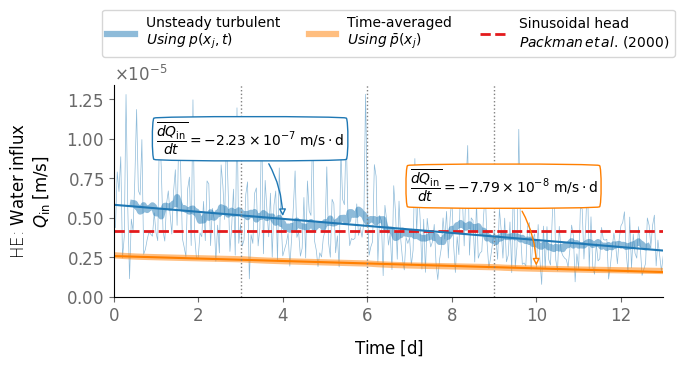

In [14]:
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00']

legLab = {'LES':'Unsteady turbulent\n' + r"${Using \; p(x_j,t)}$",
          'RAS':'Time-averaged\n' + r"${Using \; \bar{p}(x_j)}$",
          'P20':'Sinusoidal head\n' + r"$\mathit{Packman\,et\,al.\,(2000)}$"}

fig,ax = plt.subplots(1,1,figsize=[7,4],squeeze=True)

ax.plot(les_turbulent['Time (d)'],-les_turbulent['sumPhiIn (m3/s)']/Axy,
        c=colors[1],alpha=0.5,lw=0.5)

ax.plot(les_turbulent['Time (d)'],-les_turbulent['sumPhiIn (m3/s)'].rolling(20,center=True).mean()/Axy,label=legLab['LES'],
        c=colors[1],alpha=0.5,lw=4.5)

ax.plot(time_averaged['Time (d)'],-time_averaged['sumPhiIn (m3/s)']/Axy,label=legLab['RAS'],
        c=colors[-1],alpha=0.5,lw=4.5)

ax.axhline(y=qBar/Axy,label=legLab['P20'],
           c=colors[5],lw=2,ls='dashed')

## Regresssions
ax.axline((0,lesreg.intercept),slope=lesreg.slope,c=colors[1],ls='-')
ax.axline((0,rasreg.intercept),slope=rasreg.slope,c=colors[-1],ls='-')

ax.set_ylim(ymin=0)

ax.set_ylabel(r"HE: ${\rm Water \; influx}$" + "\n" + r"$Q_\mathsf{in} \; \mathsf{[m/s]}$")
ax.legend(loc="lower center", bbox_to_anchor=(0.5,1.1),ncol=3)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)

kw_clayinjections = dict(lw=1,c='gray',ls='dotted')

ax.axvline(x=3,**kw_clayinjections)
ax.axvline(x=6,**kw_clayinjections)
ax.axvline(x=9,**kw_clayinjections)

ax.set_xlabel(r"$\mathsf{Time \; [d]}$")
ax.set_xlim(0,13)
ax.annotate(r"$\overline{\dfrac{dQ_{\mathsf{in}}}{dt}} = $" + sci_notation(lesreg.slope,2) + r" $\mathsf{m/s\cdot d}$", 
              xy=(4.0, lesreg.slope * 4.0 + lesreg.intercept), xycoords='data',
              xytext=(1.0, 1.0E-5), textcoords='data',
              size=10, va="center", ha="left",
              bbox=dict(boxstyle="round4", fc="w",ec=colors[1],ls='-'),
              arrowprops=dict(arrowstyle="-|>",ls='-',
                              connectionstyle="arc3,rad=-0.2",
                              fc="w",ec=colors[1]))

ax.annotate(r"$\overline{\dfrac{dQ_{\mathsf{in}}}{dt}} = $" + sci_notation(rasreg.slope,2) + r" $\mathsf{m/s\cdot d}$", 
              xy=(10.0, rasreg.slope * 10.0 + rasreg.intercept), xycoords='data',
              xytext=(7.0, 0.7E-5), textcoords='data',
              size=10, va="center", ha="left",
              bbox=dict(boxstyle="round4", fc="w",ec=colors[-1],ls='-'),
              arrowprops=dict(arrowstyle="-|>",ls='-',
                              connectionstyle="arc3,rad=-0.2",
                              fc="w",ec=colors[-1]))


fig.tight_layout()
# plt.savefig("Suppl.Figure - InterfaceFluxes_pretty.pdf")
plt.show()

### Plot Figure 3

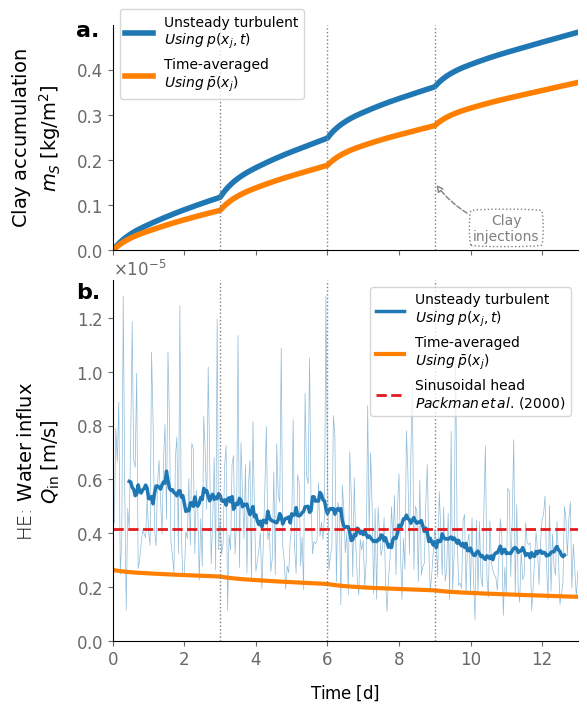

In [15]:
legLab = {'LES':'Unsteady turbulent\n' + r"${Using \; p(x_j,t)}$",
          'RAS':'Time-averaged\n' + r"${Using \; \bar{p}(x_j)}$",
          'P20':'Sinusoidal head\n' + r"$\mathit{Packman\,et\,al.\,(2000)}$"}

fig,axs = plt.subplots(2,1,figsize=[6,8],sharex=True,
                       gridspec_kw={"hspace":0.1,"height_ratios":[1,1.6]})

######################
ax = axs[0]

ax.plot(LESv['Time (d)'],LESv['depositedClay']/Axy,
        lw=4,label=legLab['LES'],c=colors[1])

ax.plot(RASv['Time (d)'],RASv['depositedClay']/Axy,
        lw=4,label=legLab['RAS'],c=colors[-1])

ax.set_ylabel(r"${\rm Clay \; accumulation}$" + "\n" + r"$m_S  \; \mathsf{[kg/m^2]}$", fontsize=14)
ax.set(xlim=[0,13],ylim=[0,0.499])
ax.legend(fontsize=10, loc='upper left',bbox_to_anchor=(0.0,1.1))

#####################
ax = axs[1]
ax.plot(les_turbulent['Time (d)'],-les_turbulent['sumPhiIn (m3/s)']/Axy,
        c=colors[1],alpha=0.5,lw=0.5)
ax.plot(les_turbulent['Time (d)'],-les_turbulent['sumPhiIn (m3/s)'].rolling(20,center=True).mean()/Axy,label=legLab['LES'],
        c=colors[1],alpha=1.0,lw=2.5)

ax.plot(time_averaged['Time (d)'],-time_averaged['sumPhiIn (m3/s)']/Axy,label=legLab['RAS'],
        c=colors[-1],lw=3)
ax.axhline(y=qBar/Axy,label=legLab['P20'],
           c=colors[5],lw=2,ls='dashed')

ax.set_ylim(ymin=0)
ax.set_ylabel(r"HE: ${\rm Water \; influx}$" + "\n" + r"$Q_\mathsf{in} \; \mathsf{[m/s]}$", fontsize=14)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
ax.legend()

########################

kw_clayinjections = dict(lw=1,c='gray',ls='dotted')

for ax,l in zip(axs,['a.','b.']):
    ax.text(-0.08,0.95,l,transform=ax.transAxes,fontsize=16,fontweight='bold')
    ax.axvline(x=3,**kw_clayinjections)
    ax.axvline(x=6,**kw_clayinjections)
    ax.axvline(x=9,**kw_clayinjections)

ann = axs[0].annotate("Clay\ninjections",c='gray',
                  xy=(9,0.15), xycoords='data',
                  xytext=(11,0.05), textcoords='data',
                  size=10, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w",ec='gray',ls='dotted'),
                  arrowprops=dict(arrowstyle="-|>",ls='dashed',
                                  connectionstyle="arc3,rad=-0.2",
                                  fc="w",ec='gray'))

ax.set_xlabel(r"$\mathsf{Time \; [d]}$")

#plt.savefig("Fig3. InterfaceFluxes_pretty.pdf", bbox_inches='tight')
plt.show()

In [16]:
print("The total mass of deposited clay was {:.3}% more for the LES than the RAS model".format(
    (LESv['depositedClay'].iloc[-1] - RASv['depositedClay'].iloc[-1])/RASv['depositedClay'].iloc[-1]*100))

The total mass of deposited clay was 29.9% more for the LES than the RAS model


## Hyporheic exchange v. Clay content

Bringing the data from Fox et. al publication

In [17]:
Figure2b_Fox2018 = {
    "Percentclaybymass" : np.array([-0.00003257328990227855, 0.011824104234527687, 0.022899022801302932, 0.031368078175895764, 0.031368078175895764, 0.04127035830618892]),
    "RelHEF" : np.array([1.0000000000000002, 0.7521126760563381, 0.5239436619718311, 0.3633802816901409, 0.34084507042253526, 0.11267605633802816])}


In [18]:
## Convert percent clay to keep units from Fox et al. 
DENSITY_OF_SAND = 2650.
CLEAN_POROSITY  = 0.358

Figure2b_Fox2018['Deposited Clay S (kg/m3)'] = Figure2b_Fox2018['Percentclaybymass'] * DENSITY_OF_SAND * (1.0 - CLEAN_POROSITY)
Figure2b_Fox2018['Deposited Clay S (kg/m3)']

lestemp = -les_turbulent['sumPhiIn (m3/s)'].rolling(20,center=True).mean().dropna()/Axy
rasreg = linregress(RASv['depositedClay']/Axy,-time_averaged['sumPhiIn (m3/s)']/Axy)
lesreg = linregress(LESv['depositedClay'][lestemp.index]/Axy,lestemp)

### Supplemental Figure S12

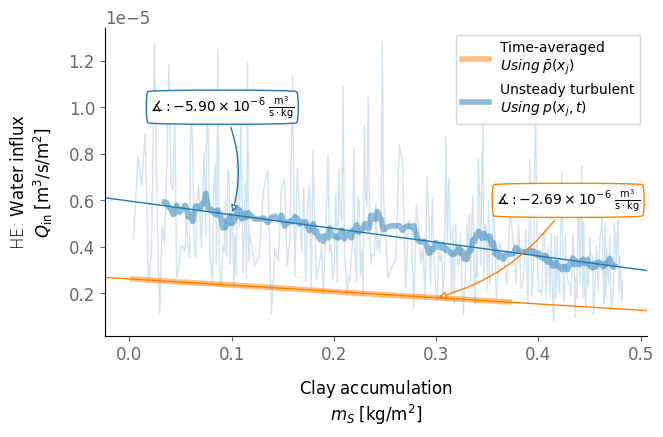

In [19]:
fig, ax = plt.subplots(1,1, figsize=[7,4],squeeze=True)

ax.plot(RASv['depositedClay']/Axy,-time_averaged['sumPhiIn (m3/s)']/Axy,
        lw=4,label=legLab['RAS'],c=colors[-1], alpha=0.5)
ax.plot(LESv['depositedClay']/Axy,-les_turbulent['sumPhiIn (m3/s)'].rolling(20,center=True).mean()/Axy,
        lw=4,label=legLab['LES'],c=colors[1], alpha=0.5)
ax.plot(LESv['depositedClay']/Axy,-les_turbulent['sumPhiIn (m3/s)']/Axy,
        lw=1,alpha=0.2,c=colors[1])

ax.axline((0.0, rasreg.intercept), slope=rasreg.slope, lw = 1, c=colors[-1])
ax.axline((0.0, lesreg.intercept), slope=lesreg.slope, lw = 1, c=colors[1])

ax.set_xlabel(r"${\rm Clay \; accumulation}$" + "\n" + r"$m_S  \; \mathsf{[kg/m^2]}$")
ax.set_ylabel(r"HE: ${\rm Water \; influx}$" + "\n" + r"$Q_\mathsf{in} \; \mathsf{[m^3/s/m^2]}$")
ax.legend()

ax.annotate(r"$\measuredangle: $" + sci_notation(lesreg.slope,2) + r" $\frac{\mathsf{m^3}}{\mathsf{s\cdot kg}}$", 
              xy=(0.1, lesreg.slope * 0.1 + lesreg.intercept), xycoords='data',
              xytext=(0.02, 1.0E-5), textcoords='data',
              size=10, va="center", ha="left",
              bbox=dict(boxstyle="round4", fc="w",ec=colors[1],ls='-'),
              arrowprops=dict(arrowstyle="-|>",ls='-',
                              connectionstyle="arc3,rad=-0.2",
                              fc="w",ec=colors[1]))

ax.annotate(r"$\measuredangle: $" + sci_notation(rasreg.slope,2) + r" $\frac{\mathsf{m^3}}{\mathsf{s\cdot kg}}$", 
              xy=(0.3, rasreg.slope * 0.3 + rasreg.intercept), xycoords='data',
              xytext=(0.5, 0.6E-5), textcoords='data',
              size=10, va="center", ha="right",
              bbox=dict(boxstyle="round4", fc="w",ec=colors[-1],ls='-'),
              arrowprops=dict(arrowstyle="-|>",ls='-',
                              connectionstyle="arc3,rad=-0.2",
                              fc="w",ec=colors[-1]))

# plt.savefig("SupplFig. HE vs deposited clay.pdf", bbox_inches='tight')
plt.show()